# Project 2: Moneyball

## Part 1: Wrangling

### Problem 1

In [14]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

#query = "SELECT Teams.yearID, Teams.teamID, Teams.franchID, W as wins, sum(salary) as total_payroll, (W*1.0/G)*100 as win_percentage FROM Salaries INNER JOIN Teams ON Teams.yearID = Salaries.yearID GROUP BY Teams.teamID, Teams.yearID"
query = "with total_payroll as (SELECT teamID, yearID, sum(salary) as total_payroll FROM Salaries GROUP BY teamID, yearID) SELECT Teams.teamID, Teams.yearID, total_payroll, franchID, W,((W*1.0/G)*100) as win_percentage FROM total_payroll, Teams WHERE total_payroll.yearID = Teams.yearID and total_payroll.teamID = Teams.teamID"
team_stats = pd.read_sql(query, conn)
#team_stats["yearID"].sort_values().unique()
team_stats[team_stats.teamID == "ANA"]

,teamID,yearID,total_payroll,franchID,W,win_percentage
320,ANA,1997,31135472.0,ANA,84,51.851852
348,ANA,1998,41281000.0,ANA,85,52.469136
378,ANA,1999,55388166.0,ANA,70,43.209877
408,ANA,2000,51464167.0,ANA,82,50.617284
438,ANA,2001,47535167.0,ANA,75,46.296296
468,ANA,2002,61721667.0,ANA,99,61.111111
498,ANA,2003,79031667.0,ANA,77,47.530864
528,ANA,2004,100534667.0,ANA,92,56.790123


In [15]:
team_stats.head(40)

,teamID,yearID,total_payroll,franchID,W,win_percentage
0,ATL,1985,14807000.0,ATL,66,40.740741
1,BAL,1985,11560712.0,BAL,83,51.552795
2,BOS,1985,10897560.0,BOS,81,49.693252
3,CAL,1985,14427894.0,ANA,90,55.555556
4,CHA,1985,9846178.0,CHW,85,52.147239
5,CHN,1985,12702917.0,CHC,77,47.530864
6,CIN,1985,8359917.0,CIN,89,54.938272
7,CLE,1985,6551666.0,CLE,60,37.037037
8,DET,1985,10348143.0,DET,84,52.173913
9,HOU,1985,9993051.0,HOU,83,51.234568


We chose to do an inner join between the Salaries and Teams tables, since this seemed most natural. Since the Salaries table does not contain any data before 1985, the inner join produces a table with team-year combinations that have only yearIDs greater than or equal to 1985, corresponding to only those combinations with actual salary data. 

## Part 2: Exploratory Data Analysis

## Payroll Distribution

To begin EDA, we will produce two plots displaying the relationship between the total payroll and time as well as winning percentage and total payroll. 

### Problem 2

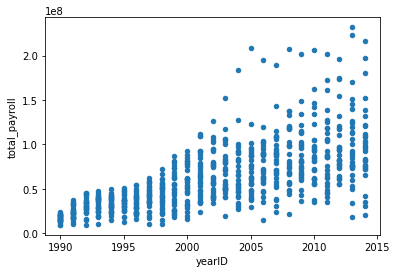

In [16]:
#Reconfigure data table to only include data from 1990 to 2014
team_stats = team_stats[team_stats.yearID >= 1990]
#produce a scatter plot of total_payroll vs. yearID
team_stats.plot.scatter("yearID", "total_payroll")

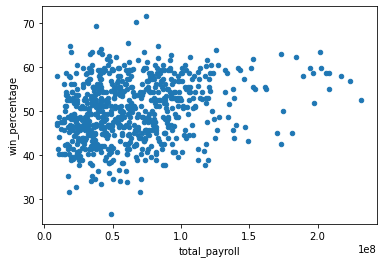

In [17]:
#Since we want to plot winning percentage as a function of total payroll, win_percentage should be on the y-axis, 
#and total_payroll on the x-axis

team_stats.plot.scatter("total_payroll", "win_percentage")

#### Question 1

From the first plot, it seems that the total_payroll increases over time. To make this clearer, we will plot the mean payroll (average over all teams) per year. It also seems that the spread of the mean payroll across teams increases as time goes on, as indicated by increased incidence of extreme values. Variance of payroll increases over time.

### Problem 3

yearID
1990    1.707235e+07
1991    2.357879e+07
1992    3.098244e+07
1993    3.220500e+07
1994    3.313701e+07
1995    3.398105e+07
1996    3.417798e+07
1997    4.026021e+07
1998    4.260943e+07
1999    4.980762e+07
2000    5.553784e+07
2001    6.535544e+07
2002    6.746925e+07
2003    7.094207e+07
2004    6.902220e+07
2005    7.295711e+07
2006    7.738242e+07
2007    8.255630e+07
2008    8.949529e+07
2009    8.882423e+07
2010    9.071200e+07
2011    9.281684e+07
2012    9.775804e+07
2013    1.011509e+08
2014    9.980002e+07
Name: total_payroll, dtype: float64


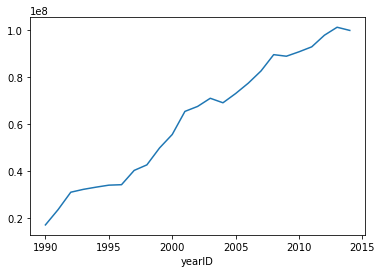

In [39]:
mean_payrolls = team_stats.groupby("yearID").mean()["total_payroll"]
mean_payrolls.plot(y="total_payroll", legend=False)

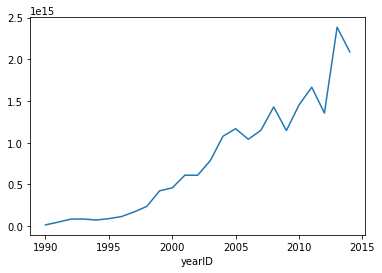

In [24]:
payrollVariance = team_stats.groupby("yearID").var()["total_payroll"]
payrollVariance.plot(y="total_payroll", legend = False)

## Correlation Between Payroll and Winning Percentage

To further investigate the relationship between payroll and winning percentage, we will create five scatter plots of mean winning percentage vs. mean payroll for five time periods (1990-1995, 1995-2000, 2000-2005, 2005-2010, 2010-2014). To do this, we will first need to calculate the mean payroll and mean winning percentage for each year. We will then discretize the data set into the aforementioned time periods. 

0.3477448639893432
0.7394512737896317
0.550451389521479
0.6772792521457238
0.47553978736494984


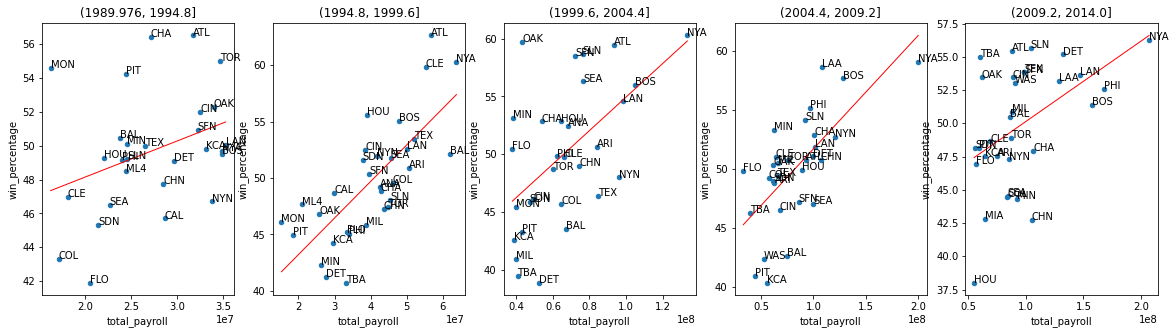

In [25]:
from scipy import stats
import numpy as np 

#define the bins
bins = [1990, 1995, 2000, 2005, 2010, 2014]

#cut the yearID into the 5 bins
team_stats["year_interval"] = pd.cut(team_stats.yearID, 5)

#invoke the axis object to plot multiple scatterplots
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i, year_range in enumerate(team_stats["year_interval"].unique()):
    #Get only relevant data to plot (i.e. within the year range)
    range_stats = team_stats[team_stats.year_interval == year_range].groupby("teamID").mean()[["total_payroll", "win_percentage"]]


    #Create a linear regression line to add to the plot 
    slope, intercept, r_value, p_value, std_err = stats.linregress(range_stats["total_payroll"],
                                                                   range_stats["win_percentage"])
    
    range_stats.plot.scatter(x="total_payroll", y="win_percentage", title=year_range, ax=ax[i])
    print(r_value)
    
    #make points, define a line, and then plot the regression
    pts = np.linspace(range_stats["total_payroll"].min(), range_stats["total_payroll"].max(), 500)
    line = slope * pts + intercept
    ax[i].plot(pts, line, lw=1, color='red')
    
    for k, v in range_stats.iterrows():
        ax[i].annotate(k, v)
    
    

Some spans ('95-'00: .74, '05-'10: .68) have a higher correlation between payroll and win percentage than others ('90-'95: .35, '09-'14: .48); the correlation does not change in a constant direction. The team with the acronym, MON (Montreal Expos, I believe), were a particularly efficient team from 1990-1995 and of course the A's were very efficient from 2000-2005. In the next five year span they joined the pack in terms of efficiency but were particularly efficient again from 2010-2015.

$$ standardizedPayroll_{ij} = \frac{payroll_{ij} - avgPayroll_{ij}}{s_j} $$

In [57]:
sumPay = {}
numTeams = {}
for i in range(1990,2015):
    sumPay[i] = 0
    numTeams[i] = 0
    

for index, row in team_stats.iterrows():
    for i in sumPay:
        if (row["yearID"] == i):
            sumPay[i] += row["total_payroll"]
            numTeams[i] += 1
            
            
avPay = {}
for i in sumPay:
    avPay[i] = sumPay[i]/numTeams[i]
    
differences = []
for index, row in team_stats.iterrows():
    for i in avPay:
        if (row["yearID"] == i):
            differences.append(row["total_payroll"] - avPay[i])
            

stds = team_stats.groupby("yearID").std()["total_payroll"]
team_stats["z_score"] = differences

for index, row in team_stats.iterrows():
    row["z_score"] = row["z_score"]/stds[row["yearID"]]



team_stats.head()

,teamID,yearID,total_payroll,franchID,W,win_percentage,year_interval,z_score
130,ATL,1990,14555501.0,ATL,65,40.123457,"(1989.976, 1994.8]",-2.516853e+06
131,BAL,1990,9680084.0,BAL,76,47.204969,"(1989.976, 1994.8]",-7.392270e+06
132,BOS,1990,20558333.0,BOS,88,54.320988,"(1989.976, 1994.8]",3.485979e+06
133,CAL,1990,21720000.0,ANA,80,49.382716,"(1989.976, 1994.8]",4.647646e+06
134,CHA,1990,9491500.0,CHW,94,58.024691,"(1989.976, 1994.8]",-7.580854e+06


0.4289195193794178
0.7820305237646521
0.550451389521479
0.6772792521457238
0.4780335654139066


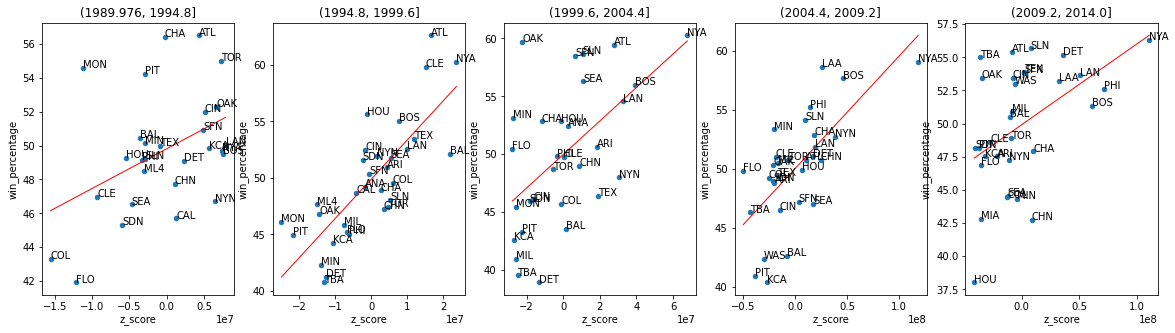

In [52]:
#define the bins
bins = [1990, 1995, 2000, 2005, 2010, 2014]

#cut the yearID into the 5 bins
team_stats["year_interval"] = pd.cut(team_stats.yearID, 5)

#invoke the axis object to plot multiple scatterplots
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i, year_range in enumerate(team_stats["year_interval"].unique()):
    #Get only relevant data to plot (i.e. within the year range)
    range_stats = team_stats[team_stats.year_interval == year_range].groupby("teamID").mean()[["z_score", "win_percentage"]]


    #Create a linear regression line to add to the plot 
    slope, intercept, r_value, p_value, std_err = stats.linregress(range_stats["z_score"],
                                                                   range_stats["win_percentage"])
    
    range_stats.plot.scatter(x="z_score", y="win_percentage", title=year_range, ax=ax[i])
    print(r_value)
    
    #make points, define a line, and then plot the regression
    pts = np.linspace(range_stats["z_score"].min(), range_stats["z_score"].max(), 500)
    line = slope * pts + intercept
    ax[i].plot(pts, line, lw=1, color='red')
    
    for k, v in range_stats.iterrows():
        ax[i].annotate(k, v)